##0. Importing torch and setting up Agnostic code

In [2]:
import torch
from torch import nn

print(torch.__version__)

2.1.0+cpu


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device:{device}')

Device:cpu


In [4]:
!nvidia-smi

Mon Oct  7 12:23:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX330         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   70C    P0             N/A / ERR!  |       0MiB /   2048MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Creating the dataset

We create a small dataset (10%) using the Food101 dataset from torchvision.datasets

Link: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

## 2. Get dataset

In [5]:
import requests
import zipfile
from pathlib import Path

#Path for data
data_path=Path('data/')
image_path=data_path / "pizza_steak_sushi"

#Creating directory
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"Creating directory {image_path}")
  image_path.mkdir(parents=True,exist_ok=True)

#Download data
with open(data_path/'pizza_steak_sushi.zip','wb') as f:
  request=requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print("Downloading the data...")
  f.write(request.content)

#Unzip file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip','r') as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall(image_path)
  print("Completed...")

data\pizza_steak_sushi directory already exists... skipping download
Unzipping file...
Completed...


## 3. Data Exploration

In [6]:
import os
def walkthrough_dir(dir_path):
  for dirpath,dirname,filename in os.walk(dir_path):
    print(f'There are {len(dirname)} directories and {len(filename)} images in {dirpath}.')
walkthrough_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [7]:
#Setup train and test paths
train_dir=image_path/"train"
test_dir=image_path/'test'

train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image Path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Iamge Height: 408
Image width: 512


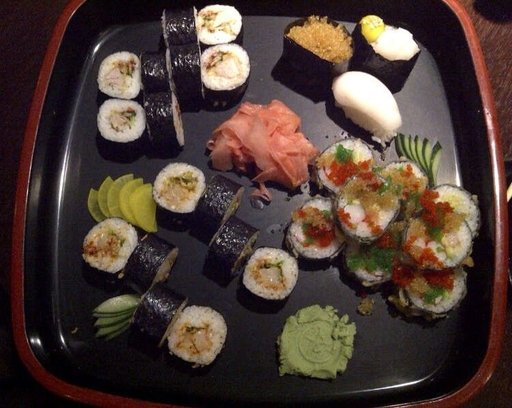

In [8]:
#Visualization a random image

import random
from PIL import Image

random.seed(42)

#Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

#Pick random image
random_image_path=random.choice(image_path_list)
random_image_path

#Get image class (i.e the directory in which image is stored)
image_class=random_image_path.parent.stem
image_class

#Display image
img=Image.open(random_image_path)

#Metadata for image
print(f"Random image Path: {random_image_path}")
print(f'Image class: {image_class}')
print(f'Iamge Height: {img.height}')
print(f'Image width: {img.width}')
img

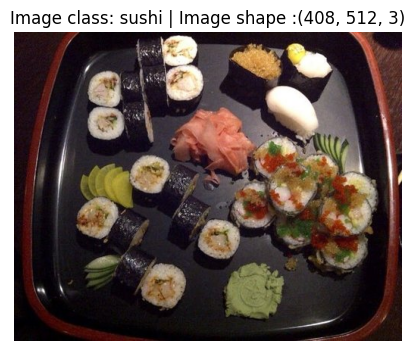

In [9]:
#Visualize using matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_array=np.array(img)

plt.figure(figsize=(5,5))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape :{img_array.shape}")
plt.axis(False)
plt.show()

## 4. Transforming the Data

We convert the images to tensor to work with Pytorch.
Also turn it into `torh.utils.data.Datasets` adn subsequently a `torch.utils.data.DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Transforming data to `torchvision.transforms`

In [12]:
#Write transform for image
data_transform=transforms.Compose([
    #Resize the images (64x64)
    transforms.Resize(size=(64,64)),

    #Flip the images
    transforms.RandomHorizontalFlip(p=0.5),

    #Turn the image to torch tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [14]:
str(random_image_path)

'data\\pizza_steak_sushi\\test\\sushi\\2394442.jpg'

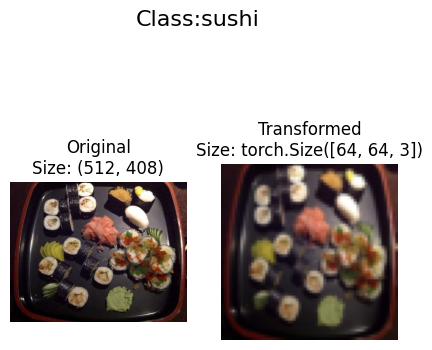

In [15]:
def plot_transformed_image(image_path,transform,n=3,seed=None):
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_path,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(5,5))
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform
      transformed_image=transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)
      
      fig.suptitle(f"Class:{image_path.parent.stem}",fontsize=16)

plot_transformed_image(image_path_list,data_transform,1,42)

### Option 1: Loading image data using `ImageFolder`

In [16]:
#Use ImageFolder to create dataset
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                          transform=data_transform,
                          target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                          transform=data_transform,
                          target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
#Get class names as a list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
#Get class names as dictionary
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
#length of data
len(train_data),len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

Image Tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

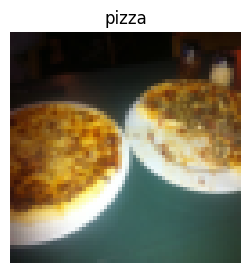

In [21]:
img,label=train_data[0][0],train_data[0][1]
print(f'Image Tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Image label datatype: {type(label)}')

plt.figure(figsize=(3,3))
plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(f"{class_names[label]}")
plt.show()

#### Turn loaded images to Data Loader

In [22]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE=1
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,#os.cpu_count()
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,#os.cpu_count()
                            shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x29d5a25af50>,
 <torch.utils.data.dataloader.DataLoader at 0x29d5a28e3b0>)

In [23]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [24]:
img,label=next(iter(train_dataloader))
print(f"Image Shape: {img.shape}")
print(f'Image label: {label.shape}')

Image Shape: torch.Size([1, 3, 64, 64])
Image label: torch.Size([1])
